# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.165846,True,4.898475
1,-2.973417,False,-2.880521
2,-2.733533,False,-1.800068
3,-0.700831,False,-0.837711
4,-1.528190,False,-1.198808
...,...,...,...
995,-1.447895,False,-1.754864
996,-3.261694,False,-3.581316
997,-1.081209,False,1.548817
998,-0.928905,False,-1.106769


<Axes: xlabel='v0'>

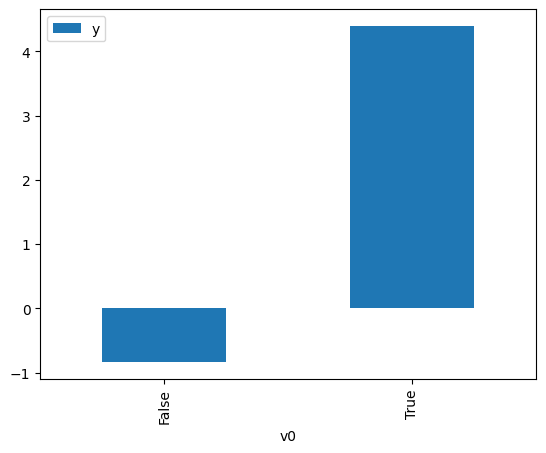

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

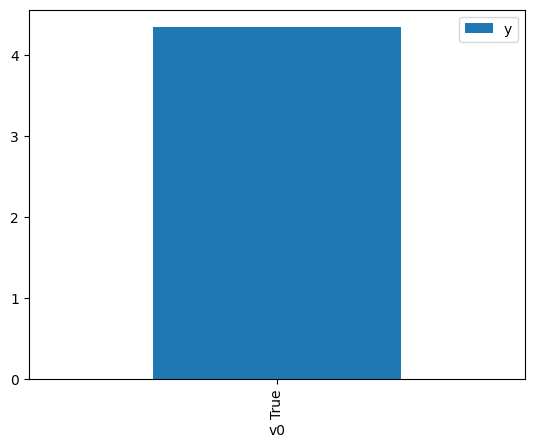

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.243252,False,-1.804566,0.864096,1.157279
1,-1.947563,False,-3.383860,0.945963,1.057124
2,0.264575,False,2.564084,0.421037,2.375088
3,-2.273290,False,-1.336138,0.965475,1.035760
4,-0.312780,False,0.573384,0.625209,1.599465
...,...,...,...,...,...
995,-0.556259,False,0.170536,0.703045,1.422384
996,-1.020518,False,-2.087888,0.821925,1.216656
997,-0.166632,False,1.032011,0.574823,1.739665
998,0.925807,False,1.583095,0.219365,4.558609


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.055647,True,5.052966,0.464569,2.152532
1,-1.247729,True,3.360896,0.135150,7.399208
2,-1.707798,True,2.187090,0.074623,13.400712
3,0.748888,True,6.964967,0.733990,1.362417
4,0.277232,True,4.834429,0.583393,1.714109
...,...,...,...,...,...
995,-1.657681,True,4.285212,0.079755,12.538462
996,-0.418750,True,4.802385,0.339818,2.942747
997,0.655487,True,5.031105,0.706957,1.414513
998,-1.301508,True,4.894662,0.126363,7.913725


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.884
Model:                            OLS   Adj. R-squared (uncentered):              0.884
Method:                 Least Squares   F-statistic:                              3820.
Date:                Mon, 27 Nov 2023   Prob (F-statistic):                        0.00
Time:                        09:18:28   Log-Likelihood:                         -1404.2
No. Observations:                1000   AIC:                                      2812.
Df Residuals:                     998   BIC:                                      2822.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8420      0.023     37.134      0.000       0.797       0.886
x2             5.0140      0.062     81.325      0.000       4.893       5.135
==============================================================================
Omnibus:                        2.726   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.256   Jarque-Bera (JB):                2.630
Skew:                           0.089   Prob(JB):                        0.269
Kurtosis:                       3.177   Cond. No.                         2.73
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""